C:\Users\bilal\AppData\Local\Temp\ipykernel_17936\772562730.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  4 of 4 completed

Raw data downloaded:
Price           Close                                        High             \
Ticker           AAPL       AMZN      GOOGL       MSFT       AAPL       AMZN   
Date                                                                           
2018-01-02  40.381004  59.450500  53.292934  79.198326  40.390383  59.500000   
2018-01-03  40.373955  60.209999  54.202164  79.566902  40.917808  60.274502   
2018-01-04  40.561501  60.479500  54.412708  80.267204  40.664645  60.793499   
2018-01-05  41.023296  61.457001  55.134235  81.262390  41.110030  61.457001   
2018-01-08  40.870934  62.343498  55.328892  81.345276  41.166300  62.653999   

Price                                   Low                                   \
Ticker          GOOGL       MSFT       AAPL       AMZN      GOOGL       MSFT   
Date                                                                           
2018-01-02  53.430486  79.530047  39.677748  58.525501  52.290351  78.783678   
2018-01-03  54.429


C:\Users\bilal\AppData\Local\Temp\ipykernel_17936\772562730.py:26: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = raw_data.stack(level=1).reset_index()



Cleaned and processed data:
          Date Ticker        Open        High         Low       Close  \
796 2018-10-16   AAPL   52.674187   52.873363   51.396159   51.910689   
797 2018-10-16   AMZN   90.998001   91.194000   88.077499   89.175003   
798 2018-10-16  GOOGL   56.265926   56.429301   55.206734   55.292640   
799 2018-10-16   MSFT  103.603592  103.986275  101.690189  102.240879   
800 2018-10-17   AAPL   52.446564   52.790374   52.007907   52.709757   

        Volume  Daily Return        MA50      MA200  Volatility  
796  116736000     -0.010083   52.092779  44.728126    0.016342  
797  117198000     -0.006407   96.267310  82.472368    0.022180  
798   38378000     -0.004043   59.630106  56.458532    0.016460  
799   31610200      0.005784  103.297643  92.594634    0.015279  
800   91541600      0.015393   52.157802  44.792231    0.016612  


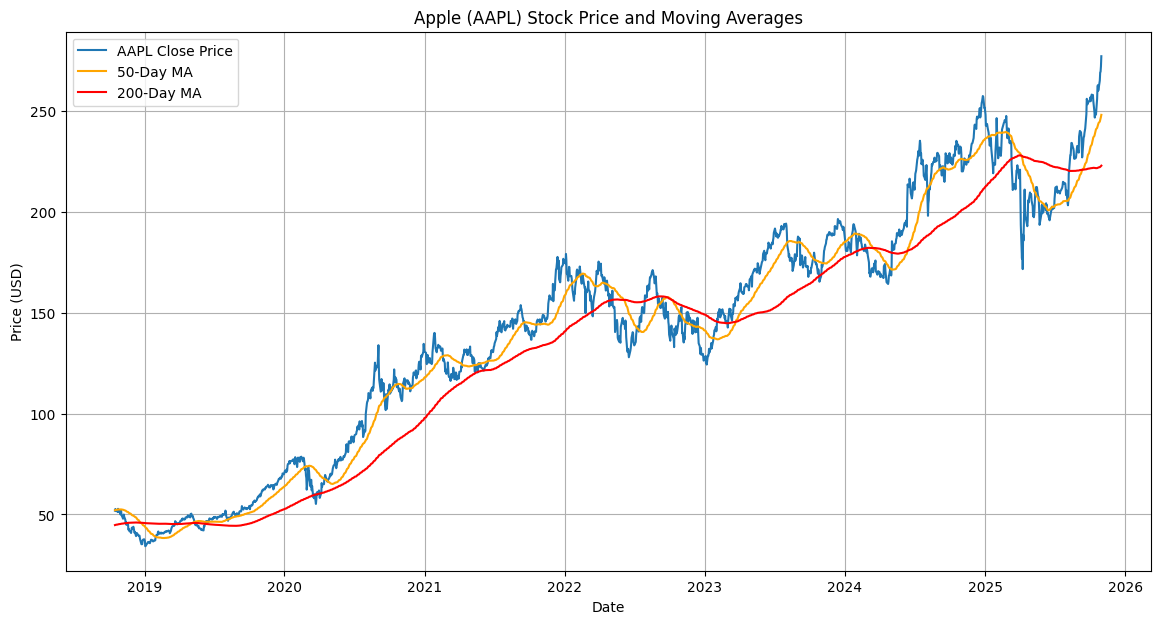

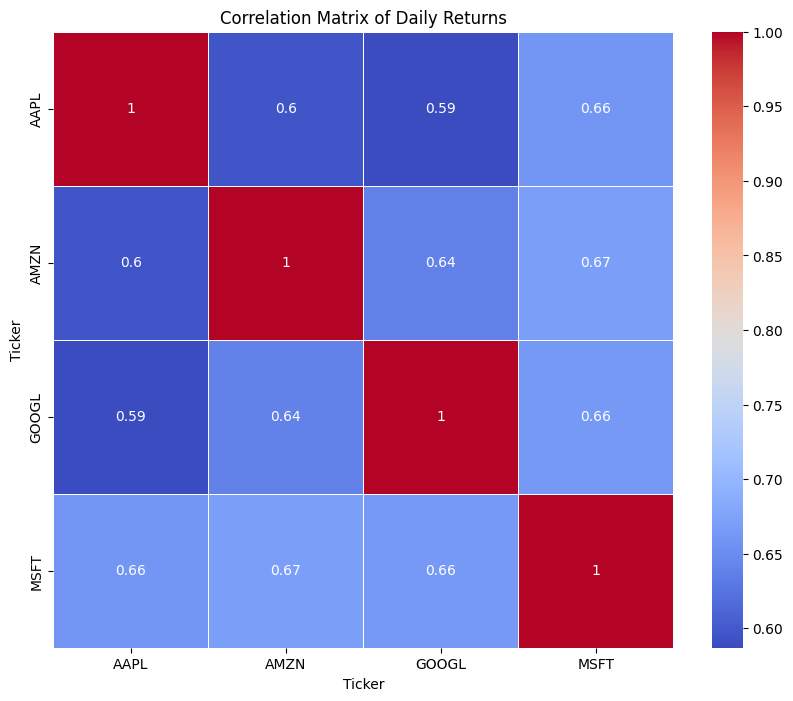


Main data saved to stock_data_for_tableau.csv
Pivoted returns data saved to daily_returns_pivot_for_tableau.csv

Script finished successfully!


In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DATA ACQUISITION ---
# Define the tickers we want to analyze
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

# Define the date range for the analysis
start_date = '2018-01-01'
end_date = datetime.now().strftime('%Y-%m-%d') # Get today's date

# Download the data using yfinance
# This will download data for all tickers into a single DataFrame with a multi-level index
print("Downloading stock data...")
raw_data = yf.download(tickers, start=start_date, end=end_date)

print("Raw data downloaded:")
print(raw_data.head())

# --- 2. DATA CLEANING & FEATURE ENGINEERING ---
# The multi-level index is hard to work with. Let's "unstack" it to a long format.
# This makes it much easier to save to a CSV and use in tools like Tableau.
df = raw_data.stack(level=1).reset_index()
df.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Calculate Daily Returns
# Daily return is the percentage change from the previous day's close
df['Daily Return'] = df.groupby('Ticker')['Close'].pct_change()

# Calculate Moving Averages (50-day and 200-day)
# These are common technical indicators that help smooth out price action
df['MA50'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=50).mean())
df['MA200'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=200).mean())

# Calculate 30-day Rolling Volatility
# Volatility is a measure of risk, calculated as the standard deviation of returns
df['Volatility'] = df.groupby('Ticker')['Daily Return'].transform(lambda x: x.rolling(window=30).std())

# Drop rows with NaN values created by rolling calculations
df.dropna(inplace=True)

print("\nCleaned and processed data:")
print(df.head())

# --- 3. EXPLORATORY ANALYSIS & VISUALIZATION (in Python) ---
# This part is for your own understanding and can be included in your GitHub repo

# Plot 1: Closing Price with Moving Averages for Apple
plt.figure(figsize=(14, 7))
aapl_data = df[df['Ticker'] == 'AAPL']
plt.plot(aapl_data['Date'], aapl_data['Close'], label='AAPL Close Price')
plt.plot(aapl_data['Date'], aapl_data['MA50'], label='50-Day MA', color='orange')
plt.plot(aapl_data['Date'], aapl_data['MA200'], label='200-Day MA', color='red')
plt.title('Apple (AAPL) Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('aapl_price_trend.png') # Save the plot
plt.show()

# Plot 2: Correlation Heatmap of Daily Returns
# First, pivot the data to have tickers as columns and dates as index
returns_pivot = df.pivot(index='Date', columns='Ticker', values='Daily Return')

# Calculate the correlation matrix
correlation_matrix = returns_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Daily Returns')
plt.savefig('correlation_heatmap.png') # Save the plot
plt.show()


# --- 4. SAVE DATA FOR TABLEAU ---
# We save the main DataFrame for the primary dashboard
output_filename = 'stock_data.csv'
df.to_csv(output_filename, index=False)
print(f"\nMain data saved to {output_filename}")

# We also save the pivoted returns data, as it's easier for a specific Tableau chart
pivoted_returns_filename = 'daily_returns_pivot_for.csv'
returns_pivot.to_csv(pivoted_returns_filename)
print(f"Pivoted returns data saved to {pivoted_returns_filename}")

print("\nScript finished successfully!")